In [1]:
import csv

def read_config_file(file_path):
    with open(file_path, mode='r') as file:
        csv_reader = csv.DictReader(file)
        return [{k.strip(): v.strip() for k, v in row.items()} for row in csv_reader]

In [2]:
map_config_file="environments\\configuration\\afghanistan\\v2\\map.csv"
MTF_config_file="environments\\configuration\\afghanistan\\v2\\MTFs.csv"
staging_area_config_file="environments\\configuration\\afghanistan\\v2\\staging_areas.csv"
casualty_cluster_center_config_file="environments\\configuration\\afghanistan\\v2\\casualty_cluster_centers.csv"

map_data = read_config_file(map_config_file)
MTF_data = read_config_file(MTF_config_file)
staging_area_data = read_config_file(staging_area_config_file)
casualty_cluster_center_data = read_config_file(casualty_cluster_center_config_file)

In [3]:
def generate_zones(self, num_zones):
    # Calculate the grid dimensions
    lat_min = self.map["lat_min"]
    lat_max = self.map["lat_max"]
    lon_min = self.map["lon_min"]
    lon_max = self.map["lon_max"]
    

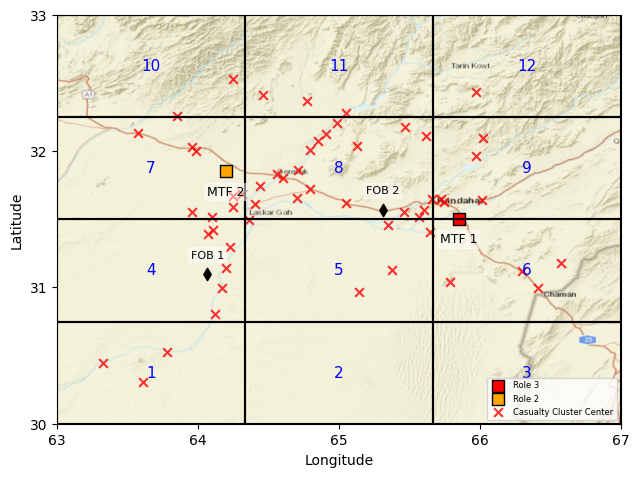

In [4]:
import contextily as ctx
import environments.utilities as utilities
import math

import matplotlib.pyplot as plt
lon_min, lon_max = float(map_data[0]['lon_min']), float(map_data[0]['lon_max'])
lat_min, lat_max = float(map_data[0]['lat_min']), float(map_data[0]['lat_max'])
aspect_ratio = (lon_max - lon_min) / (lat_max - lat_min)


plt.figure(figsize=(6.5, 6.5 / aspect_ratio))
plt.xlim(float(map_data[0]['lon_min']), float(map_data[0]['lon_max']))
plt.ylim(float(map_data[0]['lat_min']), float(map_data[0]['lat_max']))
def plot_scatter(data, lat_key, lon_key, **kwargs):
    plt.scatter([float(item[lon_key]) for item in data], [float(item[lat_key]) for item in data], **kwargs)

plt.xlabel('Longitude') 
plt.ylabel('Latitude')

# Convert latitude and longitude to Web Mercator format
x, y = zip(*[(float(item['longitude']), float(item['latitude'])) for item in MTF_data])
x_staging, y_staging = zip(*[(float(item['longitude']), float(item['latitude'])) for item in staging_area_data])
x_casualty, y_casualty = zip(*[(float(item['lon']), float(item['lat'])) for item in casualty_cluster_center_data])

# Plot the map using contextily
ax = plt.gca()
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Esri.WorldStreetMap, attribution=False)

# Plot the points again after adding the basemap
plt.scatter(x[0], y[0], marker='s', s=80, color="red", label='Role 3', edgecolors='black', linewidths=1)
plt.scatter(x[1], y[1], marker='s', s=80, color="orange", label='Role 2', edgecolors='black', linewidths=1)
plt.scatter(x_staging[2:], y_staging[2:], marker='d', s=40, color="black")
plt.scatter(x_casualty, y_casualty, marker='x', s=40, color="red", alpha=0.8, label='Casualty Cluster Center')

num_zones = 12
num_rows = int(math.sqrt(num_zones * aspect_ratio))
num_cols = int(math.ceil(num_zones / num_rows))

# Adjust if the rows and columns don't multiply exactly to num_zones
if num_rows * num_cols < num_zones:
    num_rows += 1

# Calculate the step size for latitude and longitude
lat_step = (lat_max - lat_min) / num_rows
lon_step = (lon_max - lon_min) / num_cols

# Generate the zones
zone_id_generator = utilities.IdGenerator()
zones = []
for row in range(num_rows):
    for col in range(num_cols):
        zone_lat_min = lat_min + row * lat_step
        zone_lat_max = zone_lat_min + lat_step
        zone_lon_min = lon_min + col * lon_step
        zone_lon_max = zone_lon_min + lon_step

        # Ensure the last zone doesn't exceed the map boundaries
        zone_lat_max = min(zone_lat_max, lat_max)
        zone_lon_max = min(zone_lon_max, lon_max)

        zone_id = zone_id_generator.next()
        zones.append(
            {
                'zone_id': zone_id,
                'lat_min': zone_lat_min,
                'lat_max': zone_lat_max,
                'lon_min': zone_lon_min,
                'lon_max': zone_lon_max,
            }
        )

        # Plot the zone
        plt.plot([zone_lon_min, zone_lon_max, zone_lon_max, zone_lon_min, zone_lon_min],
                 [zone_lat_min, zone_lat_min, zone_lat_max, zone_lat_max, zone_lat_min], 'k-')
        plt.text((zone_lon_min + zone_lon_max) / 2, (zone_lat_min + zone_lat_max) / 2, str(zone_id),
                 ha='center', va='center', fontsize=11, color='blue')


# Add labels next to MTFs with more padding
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord-0.2, f'MTF {i+1}', fontsize=9, ha='center', va='bottom', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))

# Add labels next to Staging Areas with more padding
for i, (x_coord, y_coord) in enumerate(zip(x_staging, y_staging)):
    if i > 1:
        plt.text(x_coord, y_coord+0.1, f'FOB {i-1}', fontsize=8, ha='center', va='bottom', 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=2))

ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend(fontsize=6, loc='lower right')
plt.tight_layout()
plt.show()